<a href="https://colab.research.google.com/github/joeyyy09/human-activity-recognition-using-lstm/blob/main/LSTM_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics

import os

In [ ]:

INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]


## Let's start by downloading the data:

In [ ]:
!unzip LSTM-Human-Activity-Recognition-master.zip

Archive:  LSTM-Human-Activity-Recognition-master.zip
5864e44a4cde5f790e91c853b2f3725617ee649f
   creating: LSTM-Human-Activity-Recognition-master/
 extracting: LSTM-Human-Activity-Recognition-master/.gitignore  
  inflating: LSTM-Human-Activity-Recognition-master/LICENSE  
  inflating: LSTM-Human-Activity-Recognition-master/LSTM.ipynb  
   creating: LSTM-Human-Activity-Recognition-master/LSTM_files/
  inflating: LSTM-Human-Activity-Recognition-master/LSTM_files/LSTM_16_0.png  
  inflating: LSTM-Human-Activity-Recognition-master/LSTM_files/LSTM_18_1.png  
  inflating: LSTM-Human-Activity-Recognition-master/README.md  
   creating: LSTM-Human-Activity-Recognition-master/data/
 extracting: LSTM-Human-Activity-Recognition-master/data/.gitignore  
  inflating: LSTM-Human-Activity-Recognition-master/data/download_dataset.py  
  inflating: LSTM-Human-Activity-Recognition-master/data/source.txt  


In [ ]:

DATA_PATH = "/content/LSTM-Human-Activity-Recognition-master/data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

/content
LSTM-Human-Activity-Recognition-master	LSTM-Human-Activity-Recognition-master.zip  sample_data
/content/LSTM-Human-Activity-Recognition-master/data
download_dataset.py  source.txt

Downloading...
--2024-06-26 07:41:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [          <=>       ]  58.17M  30.3MB/s    in 1.9s    

2024-06-26 07:41:46 (30.3 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]


Extracting...
Extracting successfully done to /content/LSTM-Human-Activity-Recognition-master/data/UCI HAR Dataset.
/content/LSTM-Human-Activity-Recognition-master/data
 download_dataset.py   __MACOSX   source.txt  'UCI HAR Dataset'  'UCI HAR Dataset.zip'
/content/

## Preparing dataset:

In [ ]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


## Additionnal Parameters:

Here are some core parameter definitions for the training.

For example, the whole neural network's structure could be summarised by enumerating those parameters and the fact that two LSTM are used one on top of another (stacked) output-to-input as hidden layers through time steps.

In [ ]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training

learning_rate = 0.0025
lambda_l2 = 0.0015
lambda_l1 = 0.001
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [ ]:
!tf_upgrade_v2 \
  --infile /content/newpy.py \
  --outfile /content/custom_regression_v2.py

2024-06-26 07:42:06.465958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 07:42:06.466043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 07:42:06.467317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 07:42:07.984279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tf_upgrade_v2", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/tools/compatibility/tf_upgrade_v2_main.py", line 156, in main
    f

In [ ]:
def LSTM_RNN(_X, _weights, _biases):

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input])
    # new shape: (n_steps*batch_size, n_input)

    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states =tf.compat.v1.nn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.

    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index]

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes
    # e.g.:
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]

    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


## Let's get serious and build the neural network:

In [ ]:
tf.compat.v1.reset_default_graph()
# Graph input/output
tf.compat.v1.disable_eager_execution()

x = tf.compat.v1.placeholder(tf.float32, shape=[None, n_steps, n_input])
y = tf.compat.v1.placeholder(tf.float32, shape=[None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.compat.v1.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.compat.v1.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.compat.v1.random_normal([n_hidden])),
    'out': tf.Variable(tf.compat.v1.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
# l2 = lambda_loss_amount * sum(
#     tf.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables()
# ) # L2 loss prevents this overkill neural network to overfit the data

# L1 and L2 regularization terms
l1_regularizer = lambda_l1 * tf.reduce_sum([tf.reduce_sum(tf.abs(var)) for var in tf.compat.v1.trainable_variables()])
l2_regularizer = lambda_l2 * tf.reduce_sum([tf.nn.l2_loss(var) for var in tf.compat.v1.trainable_variables()])
regularization_term = l1_regularizer + l2_regularizer

# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
# optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

# Loss, optimizer, and evaluation
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + regularization_term  # Softmax loss with regularization
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)  # Adam Optimizer


correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


<ipython-input-8-0ca745262889>:15: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
<ipython-input-8-0ca745262889>:16: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Hooray, now train the neural network:

In [ ]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(log_device_placement=True))
init = tf.compat.v1.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs,
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Evaluate network only at some steps for faster training:
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy],
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Device mapping: no known devices.
Training iter #1500:   Batch Loss = 5.287468, Accuracy = 0.15333333611488342
PERFORMANCE ON TEST SET: Batch Loss = 4.628119468688965, Accuracy = 0.2334577590227127
Training iter #30000:   Batch Loss = 3.243718, Accuracy = 0.6333333253860474
PERFORMANCE ON TEST SET: Batch Loss = 3.2837657928466797, Accuracy = 0.649474024772644
Training iter #60000:   Batch Loss = 2.757065, Accuracy = 0.7473333477973938
PERFORMANCE ON TEST SET: Batch Loss = 2.8763387203216553, Accuracy = 0.7139464020729065
Training iter #90000:   Batch Loss = 2.416846, Accuracy = 0.8453333377838135
PERFORMANCE ON TEST SET: Batch Loss = 2.5801799297332764, Accuracy = 0.7594163417816162
Training iter #120000:   Batch Loss = 2.158589, Accuracy = 0.8786666393280029
PERFORMANCE ON TEST SET: Batch Loss = 2.394792079925537, Accuracy = 0.7872412800788879
Training iter #150000:   Batch Loss = 1.939265, Accuracy = 0.9160000085830688
PERFORMANCE ON TEST SET: Batch Loss = 2.253988027572632, Accuracy

## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

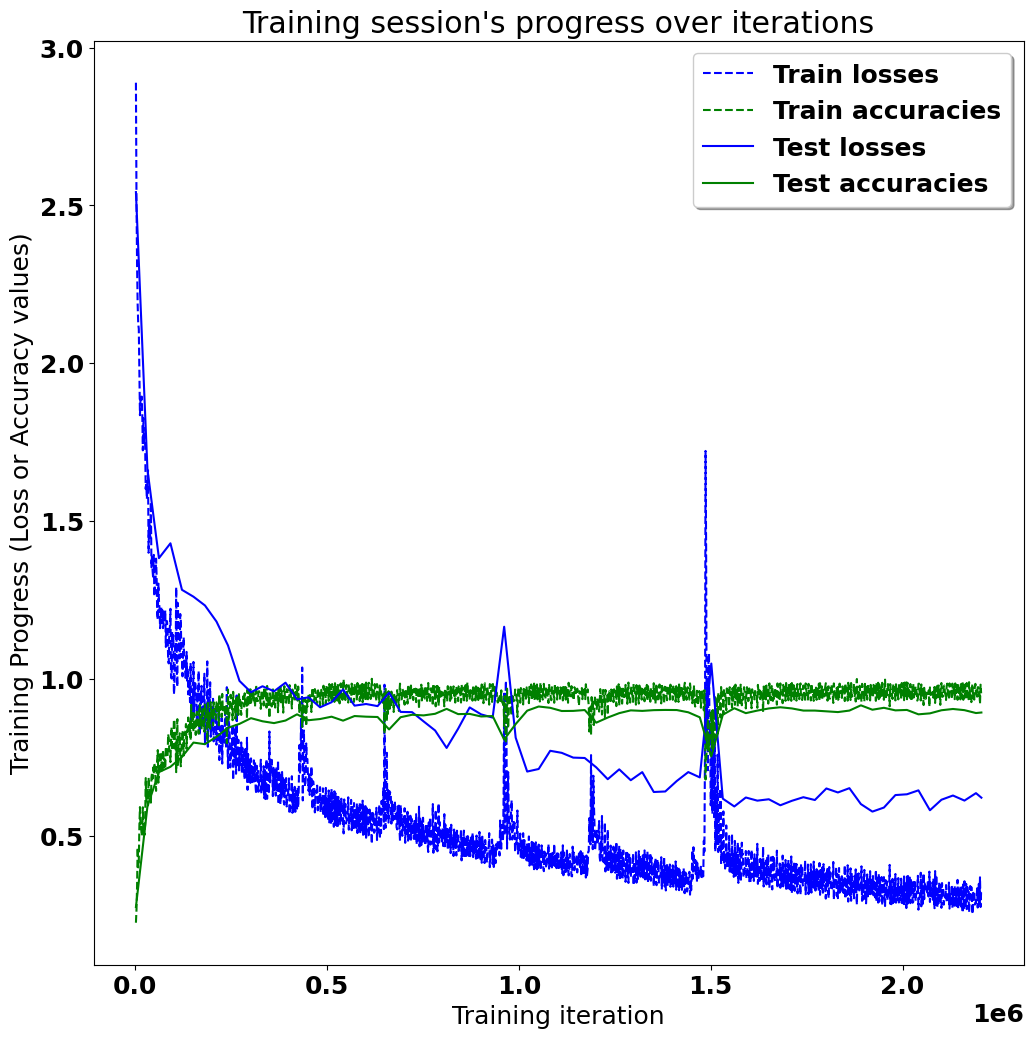

In [ ]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: 89.24329876899719%

Precision: 89.35121718932659%
Recall: 89.24329826942655%
f1_score: 89.23299772724921%

Confusion Matrix:
[[466   2  26   1   1   0]
 [ 32 417  22   0   0   0]
 [ 16   0 404   0   0   0]
 [  0  22   2 405  62   0]
 [  1   4   0  99 428   0]
 [  0  27   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[15.812691    0.06786563  0.88225317  0.03393281  0.03393281  0.        ]
 [ 1.08585    14.149983    0.7465219   0.          0.          0.        ]
 [ 0.542925    0.         13.708857    0.          0.          0.        ]
 [ 0.          0.7465219   0.06786563 13.742789    2.1038344   0.        ]
 [ 0.03393281  0.13573125  0.          3.3593483  14.523244    0.        ]
 [ 0.          0.916186    0.          0.          0.         17.305735  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


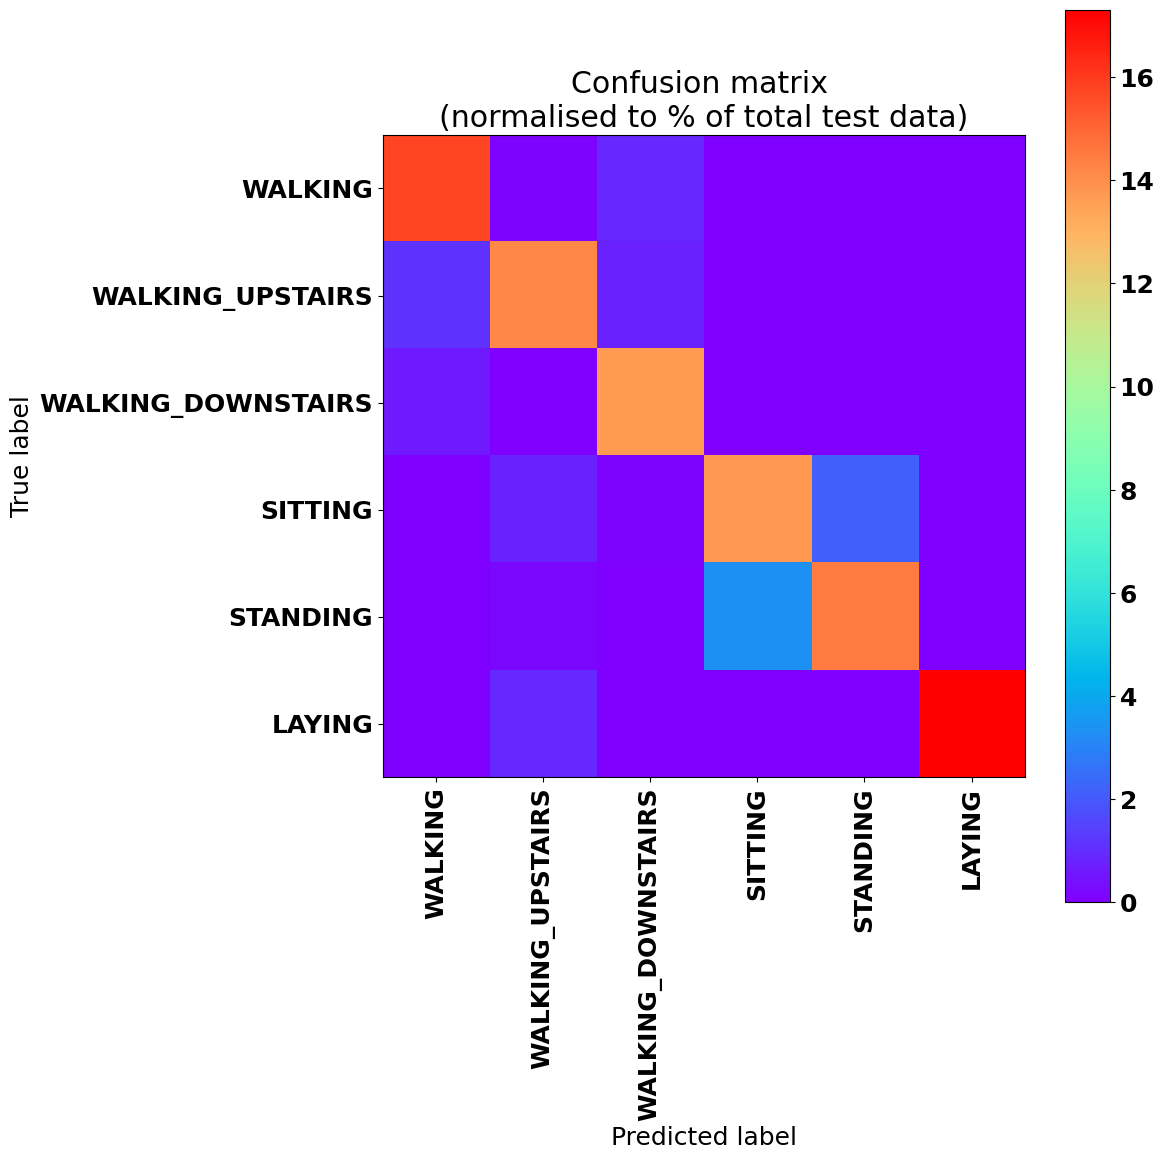

In [ ]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
sess.close()